# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB03.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Lorenzo Calandra Buonaura<br>
**ID Number**:  2107761

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

---

## Define the helper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [7]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2107761
np.random.seed(ID)


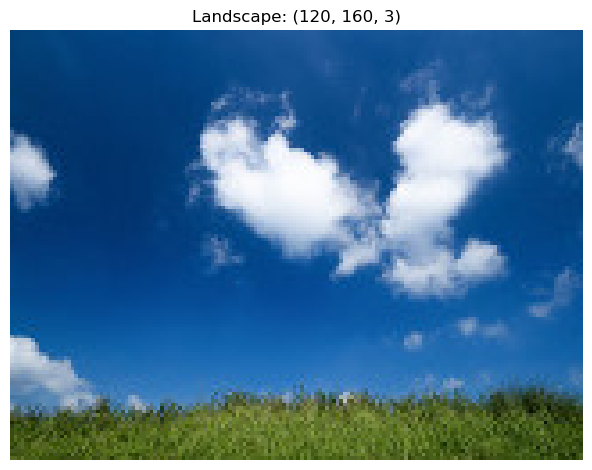

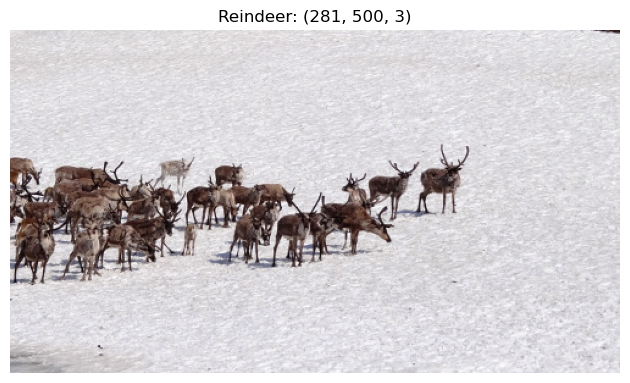

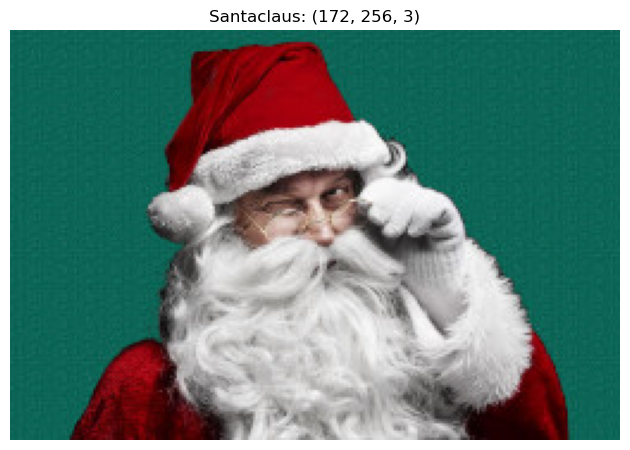

In [8]:
# Load the provided images and display them (if you like you can experiment with other images)
# To load the images use the function plt.imread(<path_to_iamge>)
# ADD YOUR CODE HERE

landscape = plt.imread('./data/landscape.jpg')
reindeer = plt.imread('./data/reindeer.jpg')
santaclaus = plt.imread('./data/santaclaus2.jpg')

# Plot the images with their shapes
# Sugestion: use the function img_plot()
# ADD YOUR CODE HERE

img_plot(landscape, 'Landscape')
img_plot(reindeer, 'Reindeer')
img_plot(santaclaus, 'Santaclaus')

We are going to start by using the Santa Claus image.


In [9]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
# ADD YOUR CODE HERE

santaclaus_reshaped = np.reshape(santaclaus, (santaclaus.shape[0] * santaclaus.shape[1], 3))
santaclaus_reshaped = santaclaus_reshaped/255

# Print the shape of the data and the min and max values of the pixels
# ADD YOUR CODE HERE

print('Shape:', santaclaus_reshaped.shape)
print('Max red:', santaclaus_reshaped[:,0].max(), '; ', 'Min red:', santaclaus_reshaped[:,0].min())
print('Max green:', santaclaus_reshaped[:,1].max(), '; ', 'Min green:', santaclaus_reshaped[:,1].min())
print('Max blue:', santaclaus_reshaped[:,2].max(), '; ', 'Min blue:', santaclaus_reshaped[:,2].min())

Shape: (44032, 3)
Max red: 1.0 ;  Min red: 0.0
Max green: 1.0 ;  Min green: 0.0
Max blue: 1.0 ;  Min blue: 0.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

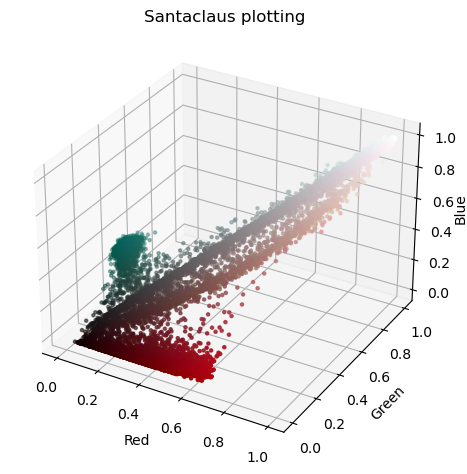

In [10]:
# Suggestion: use the function scatter_plot()
# ADD YOUR CODE HERE

scatter_plot(santaclaus_reshaped, title='Santaclaus plotting')

### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [11]:
def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data
    
    # ADD YOUR CODE HERE
    centroids = points.mean() + points.std() * np.random.rand(k, points.shape[1])
      
    prev_error = 100000
    error = [9999]
    
    # Iterate until the estimate of that center stays the same or max iteration are reached
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # Measure the distance to every center
        distances = []
        for point in points:
            distances.append([np.linalg.norm(point-centroid) for centroid in centroids])

        # Assign all training data to closest center
        clusters = np.zeros(points.shape[0])
        
        for i in range(len(distances)):
            index_min = np.argmin(distances[i])
            clusters[i] = index_min
                
        # Calculate mean for every cluster and update the center
        for i in range(k):
            centroids[i] = np.mean(points[clusters == i], axis=0)
        
        # Update the error
        err = 0
        for i in range(k):
            for point in points[clusters == i]:
                err += (np.linalg.norm(point-centroids[i]))**2
        
        error.append(err)
        
        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

[9999, 1437.5758532995821, 1113.2512857024303, 1093.6601983950463, 1092.9463402678316, 1092.8956307010712, 1092.8785337718543, 1092.8768677600403, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816, 1092.87654974816]


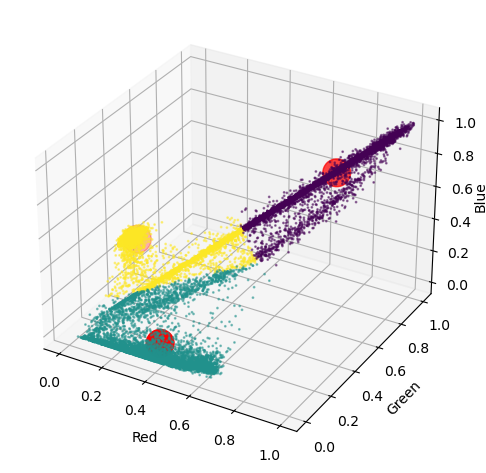

In [12]:
# Run your K-means function on the data
my_kmeans_results = my_kmeans(santaclaus_reshaped,  3)
centroids, clusters, error = my_kmeans_results

# Print the errors:
print(error)

# Plot the results
scatter_plot(santaclaus_reshaped, clusters, centroids)

### TO DO (A.3) 
Plot the value of the error versus the number of iterations

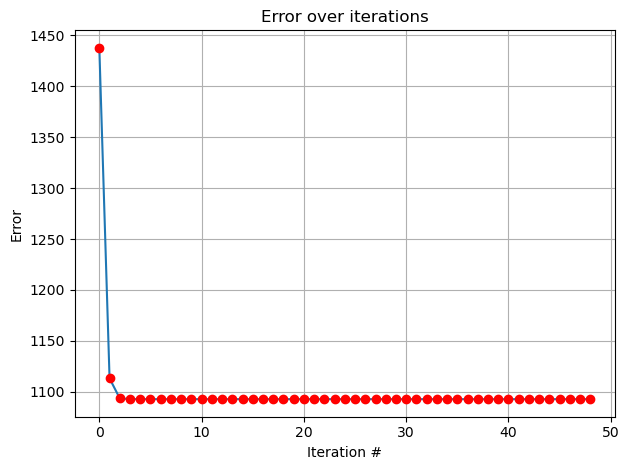

In [13]:
# Suggestion: use the function error_plot()
error_plot(error)

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [27]:
# Define the K-means model
kmeans_model = KMeans(3, n_init=15)

# Fit the model to the data
kmeans_model.fit(santaclaus_reshaped)

# Get the cluster centers
print(kmeans_model.cluster_centers_)

[[0.77990258 0.77032897 0.76764366]
 [0.07869535 0.39460407 0.34307961]
 [0.39275069 0.05321012 0.06652997]] [1 1 1 ... 1 1 1]


Perform the same plot as above but with the output of the k-means function provided in sklearn.

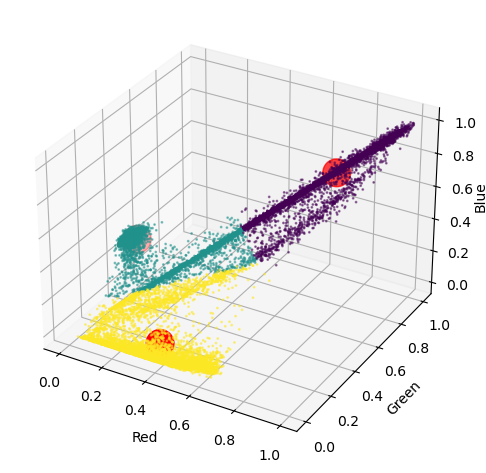

In [22]:
scatter_plot(santaclaus_reshaped, kmeans_model.labels_, kmeans_model.cluster_centers_)

### TO DO (A.Q1) [Answare the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q2:** Answer here

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

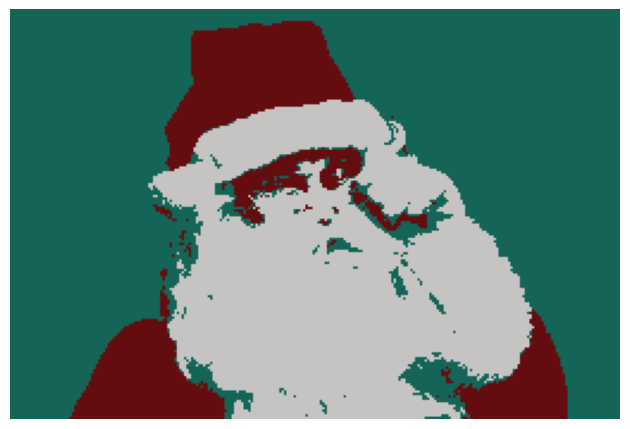

In [25]:
# Extract the color values of the centers
centers_color = kmeans_model.cluster_centers_

# Reshape the data to the original image shape
santaclaus_new = centers_color[kmeans_model.labels_].reshape(santaclaus.shape)

# Plot the recolored image
img_plot(santaclaus_new)

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

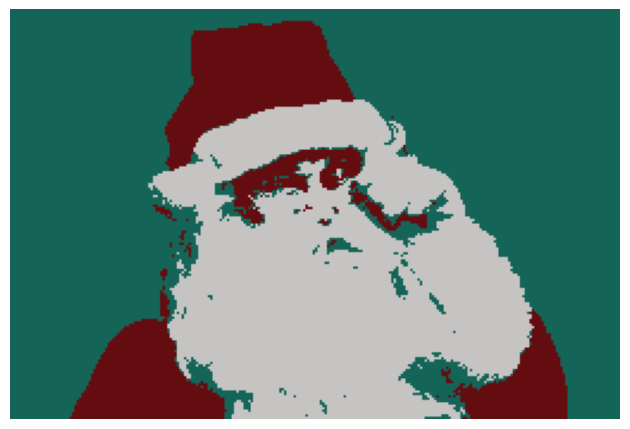

In [40]:
# Extarct the color values of the centers
my_centers_color = centroids

# Reshape the data to the original image shape
my_santaclaus_new = my_centers_color[clusters.astype(int)].reshape(santaclaus.shape)
    
# Plot the recolored image
img_plot(my_santaclaus_new)

### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q1:** Answer here

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

Shape: (44032, 3)
Max red: 1.0 ;  Min red: 0.0
Max green: 1.0 ;  Min green: 0.0
Max blue: 1.0 ;  Min blue: 0.0

K-means clustering with different values of K (2-15):
[[0.11763393 0.33532013 0.50391298]
 [0.73826578 0.79685963 0.87819602]]


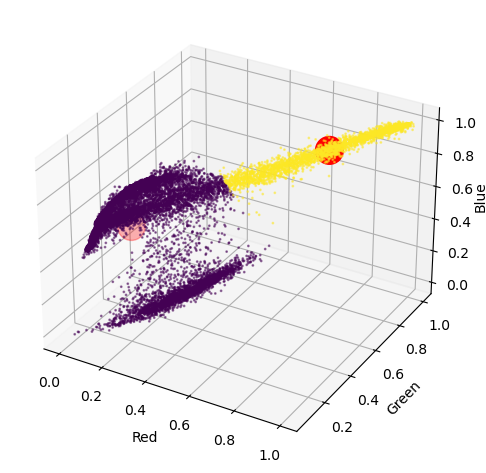

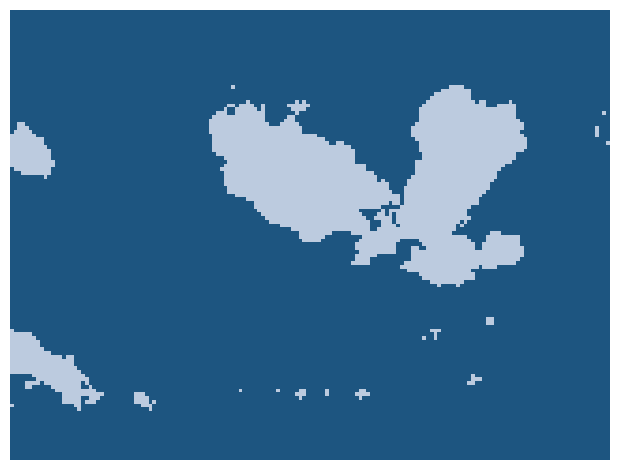

[[0.08159491 0.32557574 0.57041941]
 [0.737668   0.79631044 0.87771695]
 [0.30991623 0.38704395 0.14724397]]


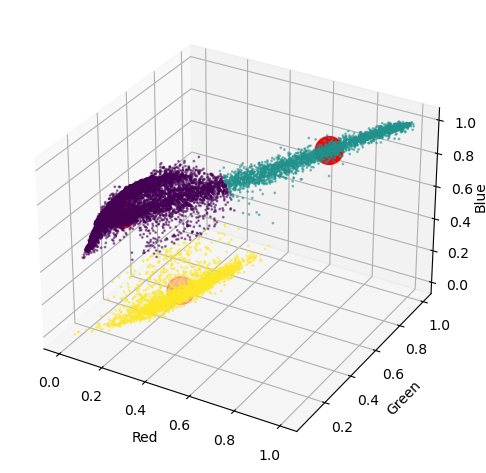

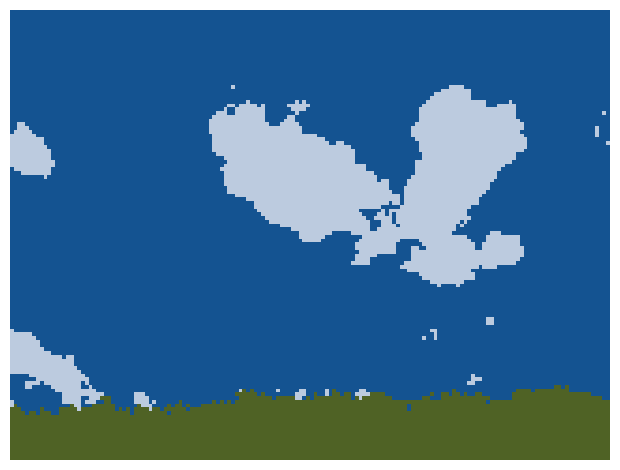

[[0.03939904 0.28669323 0.53513883]
 [0.78598266 0.83384827 0.90272396]
 [0.30928592 0.38657769 0.14594055]
 [0.2438571  0.4636637  0.68695419]]


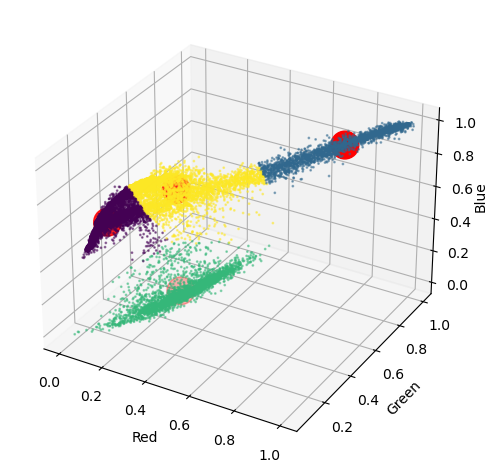

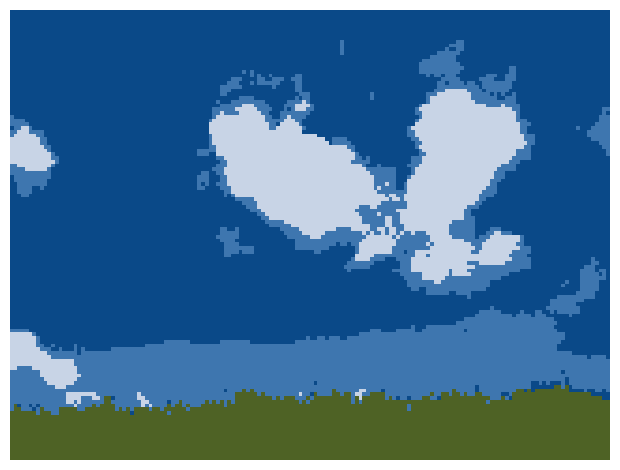

[[0.03252171 0.27569353 0.52162837]
 [0.85784551 0.89031714 0.93977828]
 [0.3096562  0.38686008 0.14620369]
 [0.16722594 0.41821698 0.6644207 ]
 [0.53049437 0.6352682  0.77110075]]


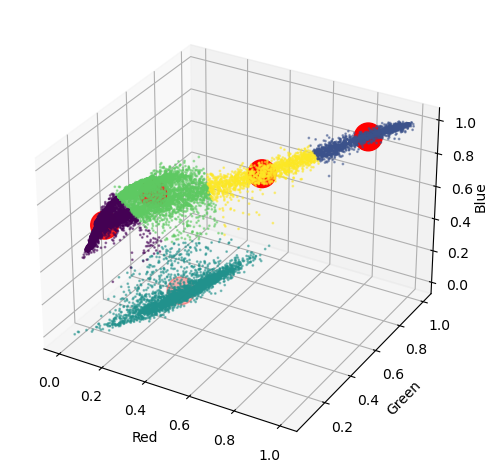

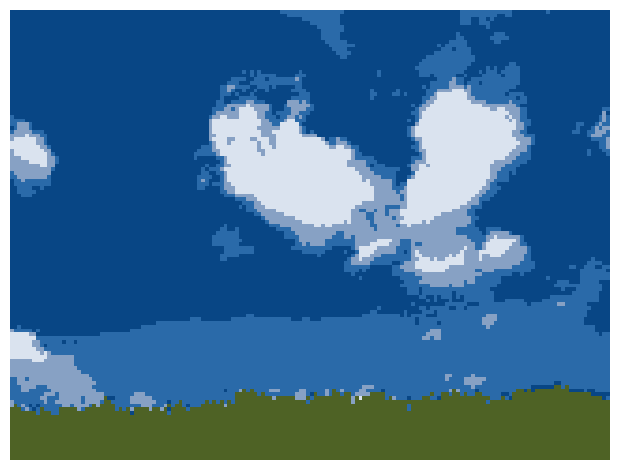

[[0.06921706 0.33330732 0.59377415]
 [0.87010768 0.89984324 0.94620564]
 [0.30986343 0.38699168 0.14586099]
 [0.57352398 0.66784034 0.79241457]
 [0.0140307  0.24578116 0.48249466]
 [0.22574601 0.45369798 0.68310111]]


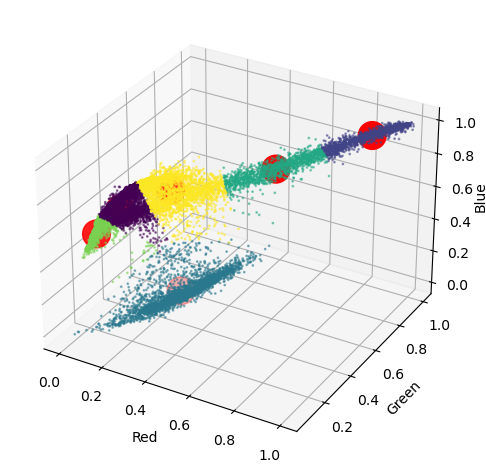

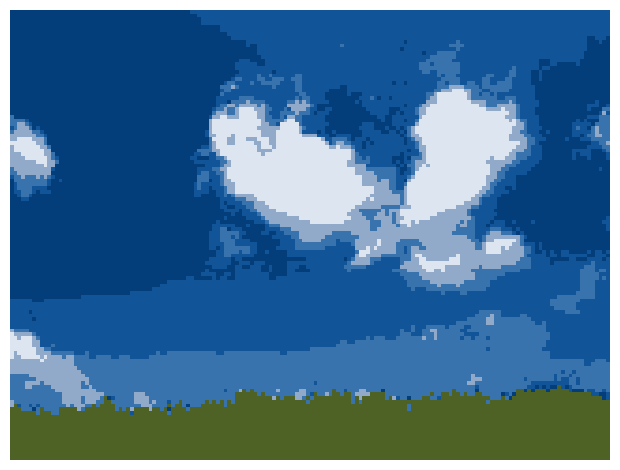

[[0.01506879 0.24769259 0.48493121]
 [0.87010768 0.89984324 0.94620564]
 [0.240248   0.31796775 0.09169874]
 [0.22671941 0.45448411 0.68425963]
 [0.07092206 0.33556831 0.59655626]
 [0.5736708  0.66790653 0.7924645 ]
 [0.37877882 0.45556663 0.20194266]]


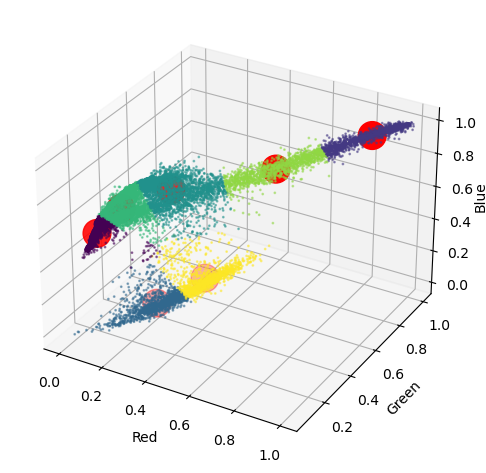

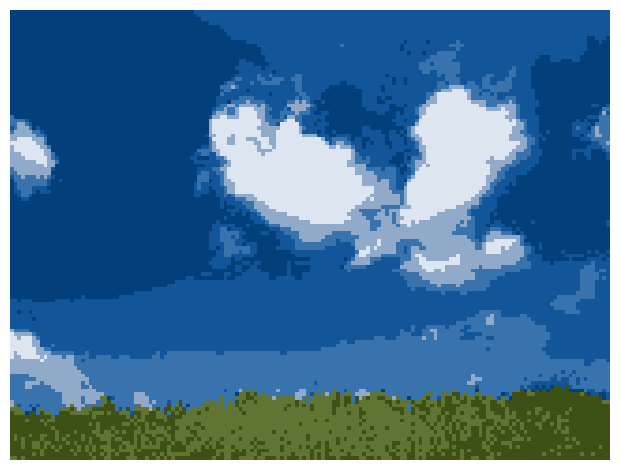

[[0.89410534 0.9188712  0.95862822]
 [0.0130541  0.24320322 0.47894886]
 [0.23712099 0.31484776 0.0896732 ]
 [0.1728246  0.4290626  0.67927686]
 [0.65223644 0.7285411  0.83340648]
 [0.37582376 0.45276134 0.19934447]
 [0.39138643 0.53584244 0.70453236]
 [0.06321333 0.32522958 0.58462661]]


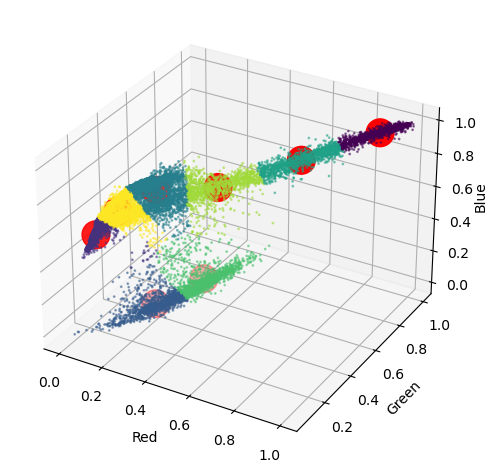

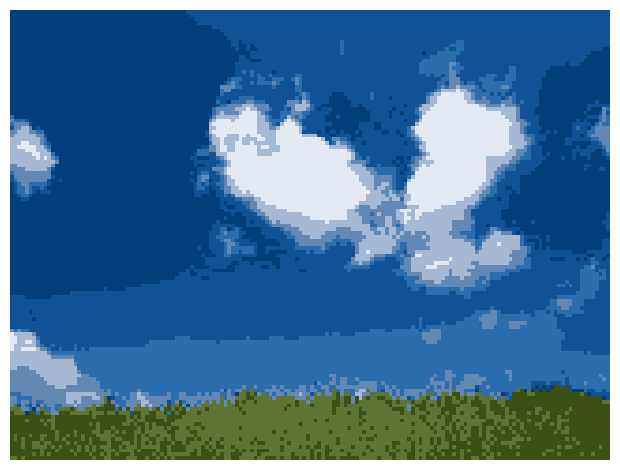

[[0.37584023 0.45272622 0.19797821]
 [0.06045636 0.32042023 0.57851822]
 [0.73074538 0.79078128 0.87575482]
 [0.14696998 0.41716452 0.67763021]
 [0.53848726 0.64029519 0.77389601]
 [0.9143797  0.93460831 0.96813307]
 [0.23687426 0.31456674 0.08959473]
 [0.01233106 0.24114592 0.47611228]
 [0.31926478 0.49216001 0.68066283]]


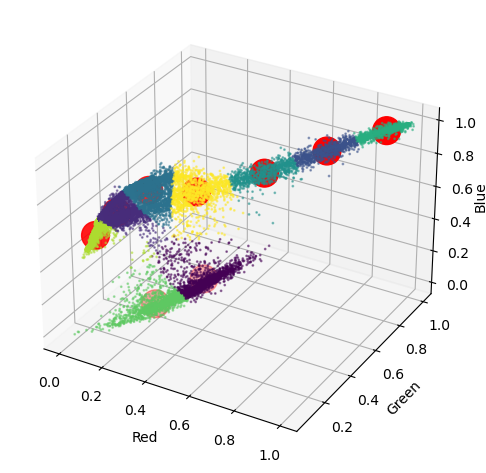

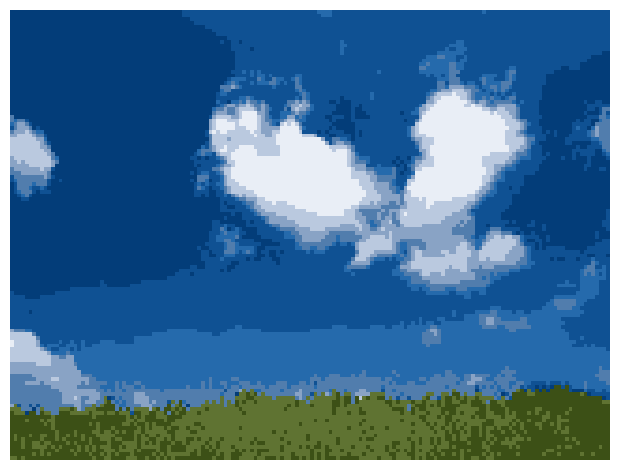

[[0.16503192 0.4298225  0.68721802]
 [0.07883341 0.34583586 0.60793073]
 [0.73294259 0.79255702 0.87702846]
 [0.3767566  0.45363409 0.19842253]
 [0.01043429 0.22603187 0.45496658]
 [0.23819184 0.31579213 0.08984216]
 [0.54250932 0.64345964 0.77632624]
 [0.91492177 0.93501187 0.9683695 ]
 [0.33206809 0.49685086 0.67852924]
 [0.03209905 0.28599123 0.5366103 ]]


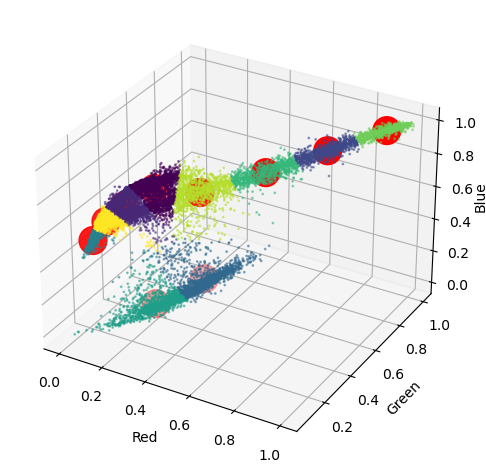

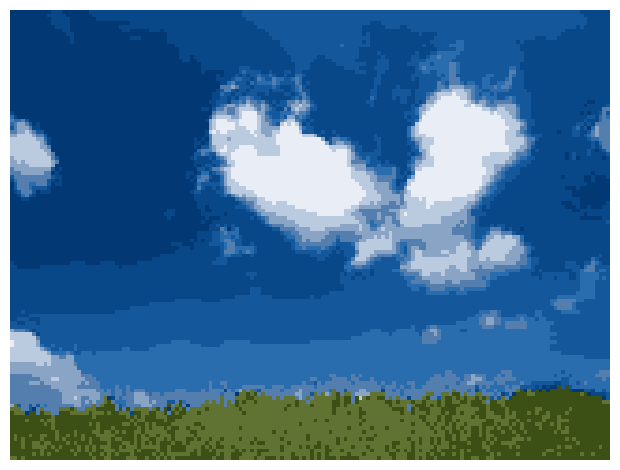

[[0.20121724 0.27717394 0.06832027]
 [0.07871604 0.34679807 0.60973674]
 [0.5427586  0.64365338 0.77643682]
 [0.01038922 0.22647028 0.45573775]
 [0.4019771  0.47722366 0.22838824]
 [0.91492177 0.93501187 0.9683695 ]
 [0.33395649 0.49792819 0.67963112]
 [0.16703146 0.43065937 0.68713543]
 [0.03317875 0.28688328 0.53739369]
 [0.3065768  0.3863822  0.13285799]
 [0.73294259 0.79255702 0.87702846]]


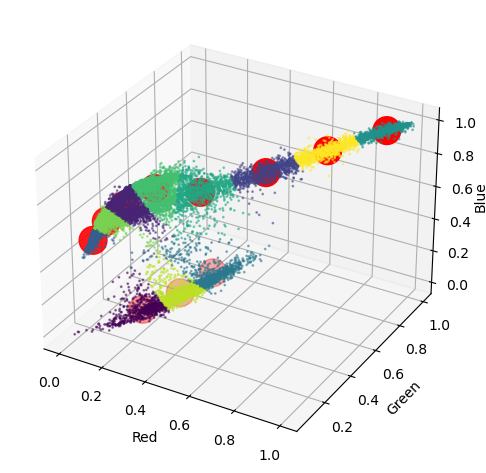

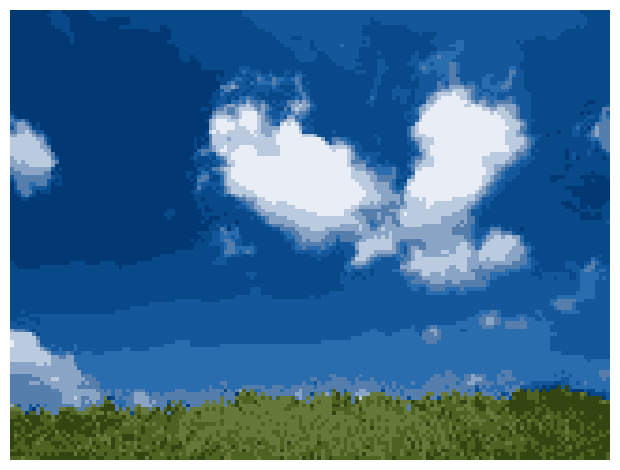

[[0.73248797 0.79220852 0.8767923 ]
 [0.03330146 0.2883564  0.54066556]
 [0.20078895 0.2765402  0.06816336]
 [0.16588884 0.42994484 0.68732212]
 [0.914831   0.93494304 0.96833613]
 [0.00971986 0.2276346  0.4584396 ]
 [0.41333123 0.48657415 0.20903643]
 [0.54237567 0.64328715 0.77597253]
 [0.07867286 0.34737983 0.61130646]
 [0.33195805 0.50018787 0.68871135]
 [0.27188022 0.38860009 0.4002888 ]
 [0.30894403 0.38780728 0.12575626]]


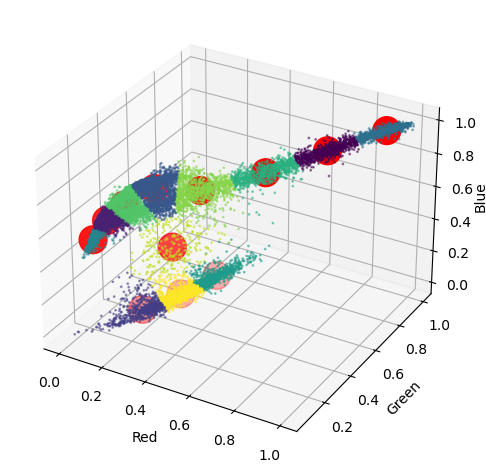

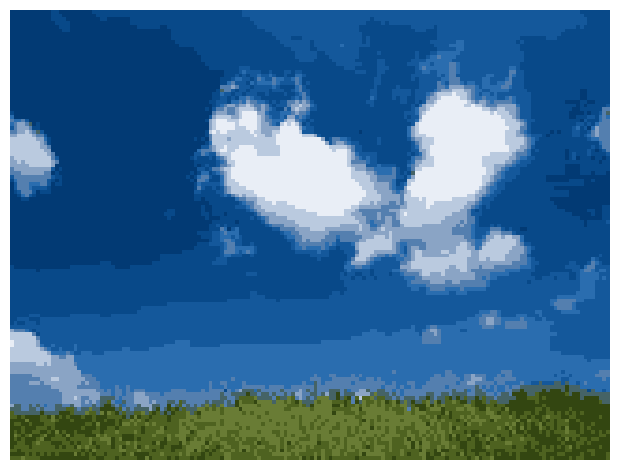

[[0.07572783 0.33792648 0.59880723]
 [0.74331872 0.80078129 0.88231766]
 [0.31271652 0.39141984 0.12888758]
 [0.40437972 0.54291636 0.70924214]
 [0.00946308 0.22551573 0.45554279]
 [0.91657339 0.93627261 0.9691186 ]
 [0.12658929 0.41394531 0.68428735]
 [0.20457697 0.28067382 0.06943451]
 [0.02845608 0.28338538 0.53481995]
 [0.57588435 0.66853923 0.79335781]
 [0.41512061 0.48827065 0.21035055]
 [0.24643979 0.45825938 0.68116366]
 [0.27386642 0.38958333 0.40015319]]


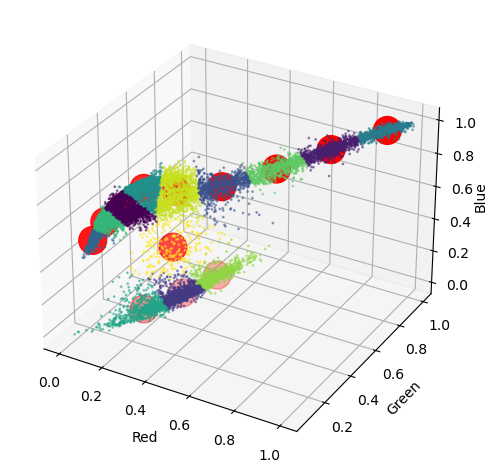

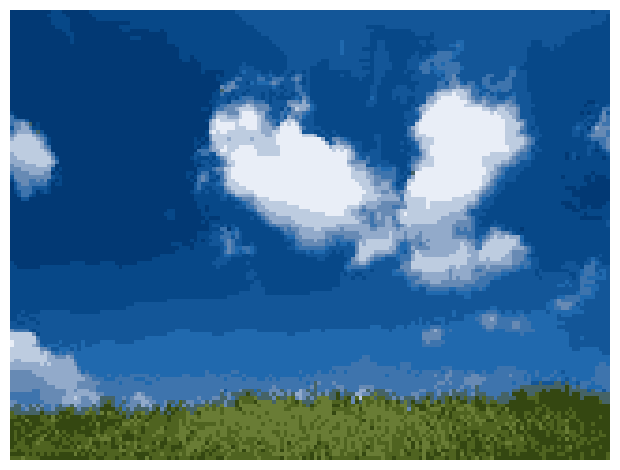

[[0.60421754 0.69065141 0.80853752]
 [0.10834408 0.33532711 0.57524672]
 [0.31277904 0.39146999 0.12691186]
 [0.76134773 0.8149834  0.89167992]
 [0.00949701 0.2255087  0.45547877]
 [0.27888347 0.4694717  0.67546194]
 [0.92023625 0.93909637 0.97089051]
 [0.14807627 0.42890716 0.69579025]
 [0.27836787 0.38698103 0.37823291]
 [0.02796361 0.28397747 0.5363266 ]
 [0.41514781 0.48829784 0.20948574]
 [0.05203919 0.3536695  0.63541831]
 [0.44045985 0.56756015 0.72585613]
 [0.20450052 0.28042493 0.06882954]]


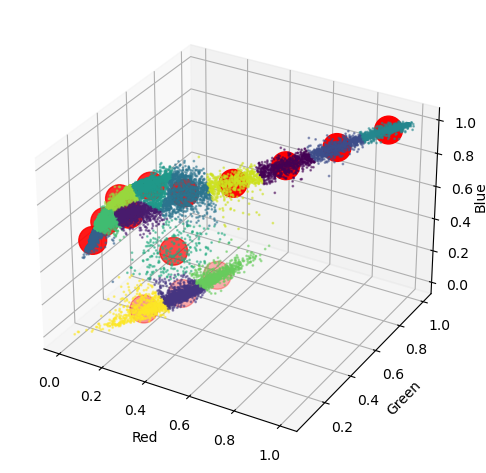

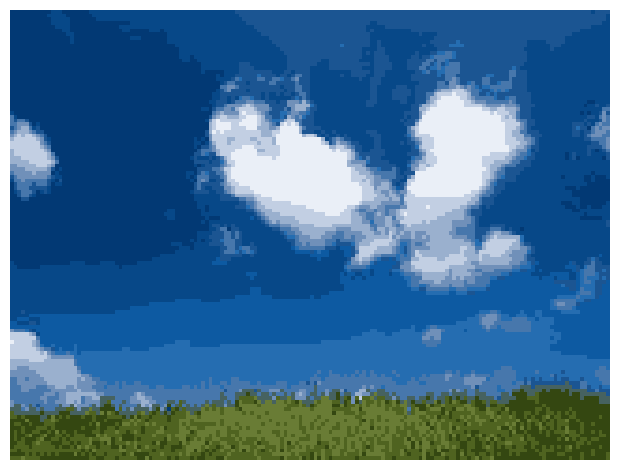

[[0.0093021  0.22353488 0.45258977]
 [0.77320949 0.82430193 0.89825151]
 [0.20506308 0.28087826 0.06784095]
 [0.22129289 0.40976307 0.6169373 ]
 [0.0933396  0.32648396 0.56954009]
 [0.49081671 0.60375789 0.74944246]
 [0.4162062  0.48927238 0.21047595]
 [0.63171895 0.71269935 0.82294118]
 [0.05398151 0.35533882 0.63682617]
 [0.31391718 0.39260413 0.12667226]
 [0.3262878  0.50108342 0.69494184]
 [0.92325697 0.94132921 0.97208669]
 [0.15095628 0.43690082 0.70641284]
 [0.02355632 0.27990936 0.53238604]
 [0.27642887 0.37977472 0.3587985 ]]


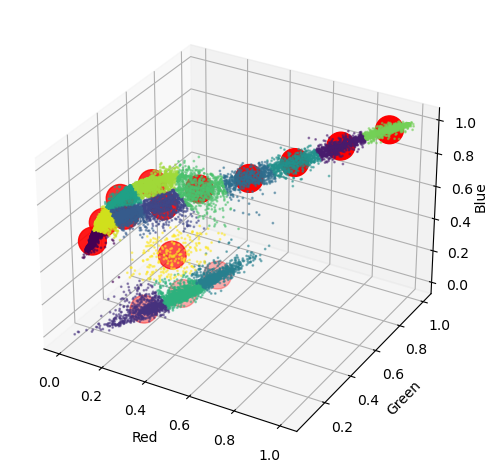

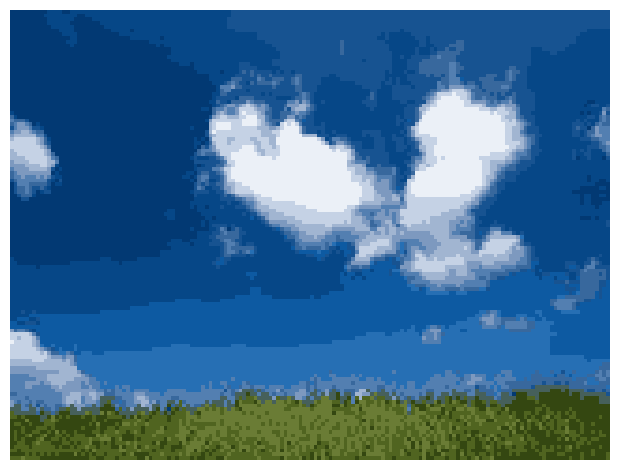

In [42]:
# Reshape the data to a matrix of total_num_pixels x 3
landscape_reshaped = np.reshape(landscape, (landscape.shape[0] * landscape.shape[1], 3))
landscape_reshaped = landscape_reshaped/255

# Print the shape of the data and the min and max values of the pixels
print('Shape:', santaclaus_reshaped.shape)
print('Max red:', santaclaus_reshaped[:,0].max(), '; ', 'Min red:', santaclaus_reshaped[:,0].min())
print('Max green:', santaclaus_reshaped[:,1].max(), '; ', 'Min green:', santaclaus_reshaped[:,1].min())
print('Max blue:', santaclaus_reshaped[:,2].max(), '; ', 'Min blue:', santaclaus_reshaped[:,2].min())

# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):
    # Define the K-means model
    landscape_model = KMeans(k, n_init=15)
    
    # Fit the model to the data
    landscape_model.fit(landscape_reshaped)

    # Get the cluster centers
    print(landscape_model.cluster_centers_)
    
    # Extract the color values of the centers
    landscape_centers_color = landscape_model.cluster_centers_

    # Reshape the data to the original image shape
    landscape_new = landscape_centers_color[landscape_model.labels_].reshape(landscape.shape)

    # Update the inertia
    inertia.append(landscape_model.inertia_)
        
    # Plot the scatter plot and the recolored image
    scatter_plot(landscape_reshaped, landscape_model.labels_, landscape_model.cluster_centers_)
    
    # Plot the recolored image
    img_plot(landscape_new)

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

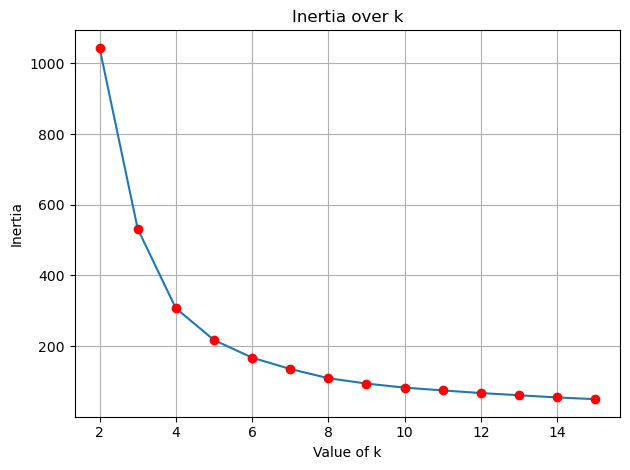

In [51]:
plt.plot(range(2, 16), inertia)
plt.plot(range(2, 16), inertia, 'ro')
plt.title('Inertia over k')
plt.ylabel('Inertia')
plt.xlabel('Value of k')
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

### TO DO (AQ.3) [Answare the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** Answer here

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [50]:
# Load sample data
data = np.load('data/moon_data.npz')

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from the sklearn library on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [56]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
agglomerative_clustering_model = AgglomerativeClustering(2, linkage='single')

# Fit the model to the data
agglomerative_clustering_model.fit_predict(x, labels_true)

# Compute the number of clusters in labels, ignoring noise if present.
labels_pred = agglomerative_clustering_model.fit_predict(x)

# Compute the number of clusters in labels, ignoring noise if present.
num_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)

# Print the results
print(f"Number of clusters: {num_clusters}")
print(labels_pred)

Number of clusters: 2
[1 0 1 ... 1 0 1]


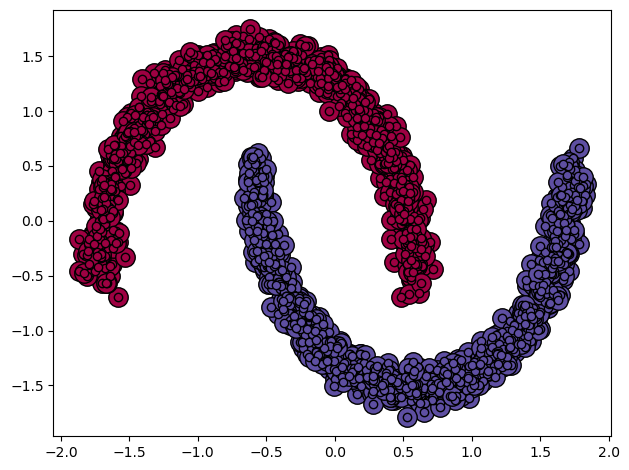

In [57]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(labels_pred, x)

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

[[-0.74339636  0.78826641]
 [ 0.73944212 -0.7840735 ]]


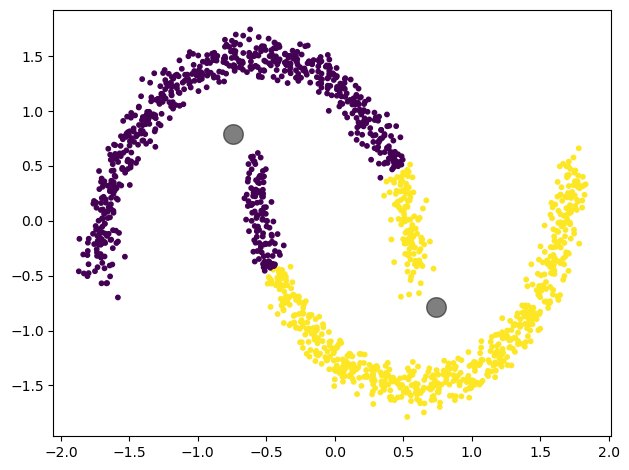

In [60]:
# Define the K-means model
kmeans_model2 = KMeans(2, n_init=15)

# Fit the model to the data
labels_pred2 = kmeans_model2.fit_predict(x, labels_true)

# Get the cluster centers
print(kmeans_model2.cluster_centers_)

# Extarct the color values of the centers
centers_color2 = kmeans_model2.cluster_centers_

# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x, labels_pred2, centers_color2)

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** Answer here

---